### HCR using LeNet

In [1]:
import numpy as np 
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image

In [25]:
from random import randint
from google.colab.patches import cv2_imshow

In [53]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input

In [4]:
X_FNAME = "alphanum-hasy-data-X.npy"
Y_FNAME = "alphanum-hasy-data-y.npy"
SYMBOL_FNAME = "symbols.csv"

In [5]:
X = np.load(X_FNAME)
y = np.load(Y_FNAME)
SYMBOLS = pd.read_csv(SYMBOL_FNAME) 
SYMBOLS = SYMBOLS[["symbol_id", "latex"]]

print("X.shape", X.shape)
print("y.shape", y.shape)
print("SYMBOLS")
SYMBOLS.head(2)

X.shape (4658, 32, 32)
y.shape (4658,)
SYMBOLS


,symbol_id,latex
0,31,A
1,32,B


<h1> Analysing the data

In [6]:
def symbol_id_to_symbol(symbol_id = None):
    if symbol_id:
        symbol_data = SYMBOLS.loc[SYMBOLS['symbol_id'] == symbol_id]
        if not symbol_data.empty:
            return str(symbol_data["latex"].values[0])
        else:
            print("This should not have happend, wrong symbol_id = ", symbol_id)
            return None
    else: 
        print("This should not have happend, no symbol id passed")
        return None        

# test some values
print("21 = ", symbol_id_to_symbol(21))
print("32 = ", symbol_id_to_symbol(32))
print("90 = ", symbol_id_to_symbol(90))

This should not have happend, wrong symbol_id =  21
21 =  None
32 =  B
90 =  a


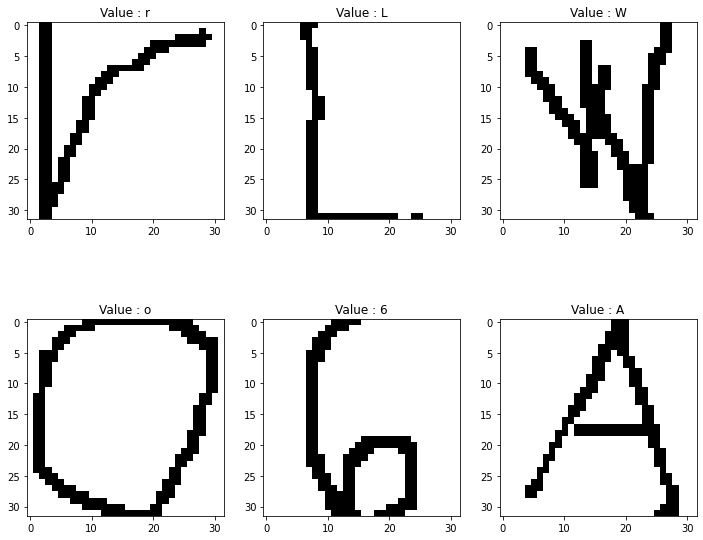

In [7]:
f, ax = plt.subplots(2, 3, figsize=(12, 10))
ax_x = 0
ax_y = 0

for i in range(6):
    randKey = randint(0, X.shape[0])
    ax[ax_x, ax_y].imshow(X[randKey], cmap='gray')
    ax[ax_x, ax_y].title.set_text("Value : " + symbol_id_to_symbol(y[randKey]))

    # for proper subplots
    if ax_x == 1:
        ax_x = 0
        ax_y = ax_y + 1
    else:
        ax_x = ax_x + 1

In [8]:
# print labels vs frequency matrix
unique, counts = np.unique(y, return_counts=True)
y_info_dict = { "labels" : unique, "counts": counts }
y_info_frame = pd.DataFrame(y_info_dict)

y_info_frame["labels"] = y_info_frame["labels"].apply(lambda x: symbol_id_to_symbol(x))
y_info_frame.head()

,labels,counts
0,A,159
1,B,61
2,C,134
3,D,58
4,E,54


In [9]:
y_info_frame.shape

(61, 2)

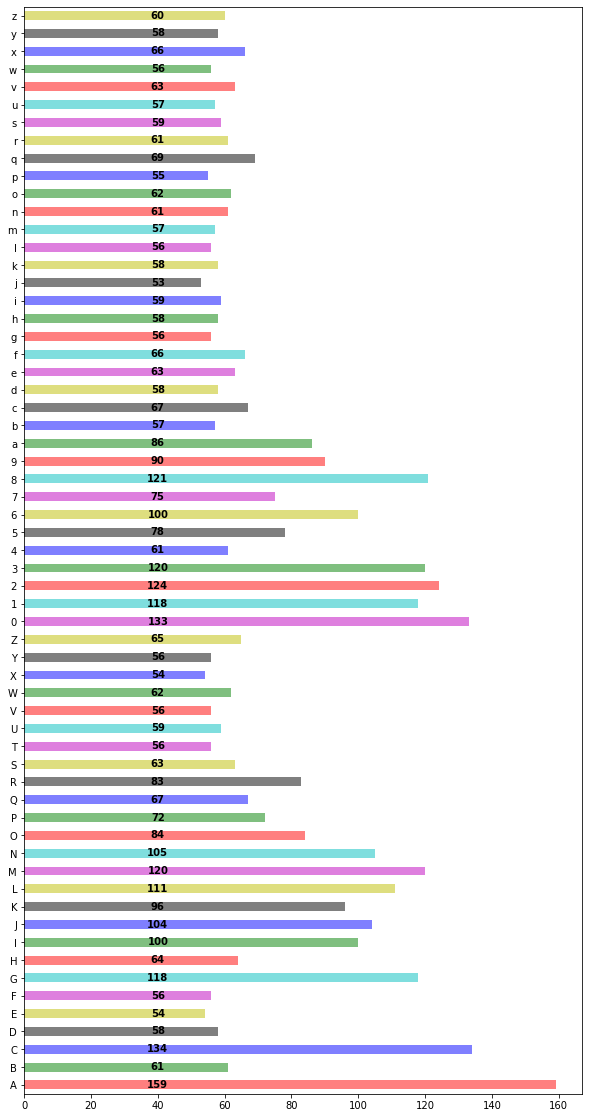

In [10]:
f, ax = plt.subplots(figsize=(10, 20))
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
y_info_frame["counts"].plot(kind='barh', legend=False, color=my_colors, alpha=0.5)
wrap = ax.set_yticklabels(list(y_info_frame["labels"]))

rects = ax.patches
bar_labels_counts = list(y_info_frame["counts"])

for i in range(len(bar_labels_counts)):
    label_value = str(bar_labels_counts[i])
    ax.text(40, rects[i].get_y(), label_value, ha='center',
          va='bottom', size='medium', color="black", fontweight="bold")

<h1> Pre processing data </h1>

In [11]:
X.shape ## already in 32*32 shape

(4658, 32, 32)

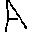

In [26]:
cv2_imshow(X[0])

In [13]:
np.unique(y)

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 110, 111, 112, 113, 114, 115])

In [14]:
y_new = []
for val in y:
  if val >=31 and val <=56:
    val = val-31
    y_new.append(val)
  elif val >=70 and val <=79:
    val = val-44
    y_new.append(val)
  else:
    val = val-54 
    y_new.append(val)

In [15]:
y_n = np.array(y_new)

In [16]:
y_n.shape

(4658,)

In [17]:
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_n, num_classes=62)

print("Shape of y:", y_onehot.shape)
print("One value of y:", y_onehot[0])

Shape of y: (4658, 62)
One value of y: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)

print("Train dataset shape")
print(X_train.shape, y_train.shape)
print("Test dataset shape")
print(X_test.shape, y_test.shape)

Train dataset shape
(3726, 32, 32) (3726, 62)
Test dataset shape
(932, 32, 32) (932, 62)


In [19]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1) #grayscale
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [20]:
# normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

<h1> LeNet model </h1>

In [21]:
np.random.seed(0)

In [54]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=62, activation = 'softmax'))

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 6)         24        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 16)          64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1296)             

# Meta-heuristic optimization

In [56]:
def simulated_annealing(ypred, y):
  cost = 0.5*tf.math.pow(tf.reduce_mean(tf.square(tf.subtract(ypred,y))), 0.5)
  return cost

In [57]:
model.compile(loss= simulated_annealing, metrics=["accuracy"], optimizer="adam")

In [58]:
history = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 20)

Epoch 1/20
117/117 [==============================] - 3s 30ms/step - loss: 0.0574 - accuracy: 0.3070
Epoch 2/20
117/117 [==============================] - 4s 31ms/step - loss: 0.0469 - accuracy: 0.5880
Epoch 3/20
117/117 [==============================] - 4s 30ms/step - loss: 0.0406 - accuracy: 0.7053
Epoch 4/20
117/117 [==============================] - 4s 30ms/step - loss: 0.0354 - accuracy: 0.7746
Epoch 5/20
117/117 [==============================] - 3s 30ms/step - loss: 0.0318 - accuracy: 0.8231
Epoch 6/20
117/117 [==============================] - 3s 29ms/step - loss: 0.0291 - accuracy: 0.8502
Epoch 7/20
117/117 [==============================] - 3s 29ms/step - loss: 0.0270 - accuracy: 0.8725
Epoch 8/20
117/117 [==============================] - 3s 29ms/step - loss: 0.0249 - accuracy: 0.8900
Epoch 9/20
117/117 [==============================] - 3s 30ms/step - loss: 0.0229 - accuracy: 0.9037
Epoch 10/20
117/117 [==============================] - 3s 29ms/step - loss: 0.0224 - accura

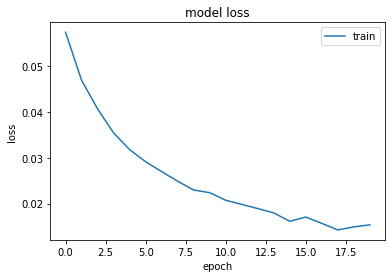

In [59]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

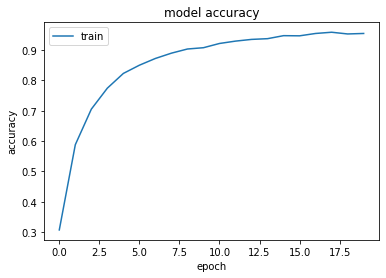

In [60]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [61]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 12ms/step - loss: 0.0456 - accuracy: 0.6792


[0.045625027269124985, 0.6791845560073853]

### Adding a dropout layer

In [ ]:
model_dropout = Sequential()
model_dropout.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model_dropout.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model_dropout.add(Dropout(rate=0.2))
model_dropout.add(Flatten())
model_dropout.add(Dense(units=120, activation='relu'))
model_dropout.add(Dense(units=84, activation='relu'))
model_dropout.add(Dense(units=62, activation = 'softmax'))

In [ ]:
model_dropout.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
history = model_dropout.fit(x = X_train, y = y_train, batch_size = 32, epochs = 15)

Epoch 1/15
117/117 [==============================] - 3s 24ms/step - loss: 3.3934 - accuracy: 0.1785
Epoch 2/15
117/117 [==============================] - 3s 24ms/step - loss: 1.8279 - accuracy: 0.4748
Epoch 3/15
117/117 [==============================] - 3s 23ms/step - loss: 1.3016 - accuracy: 0.5947
Epoch 4/15
117/117 [==============================] - 3s 23ms/step - loss: 1.0334 - accuracy: 0.6669
Epoch 5/15
117/117 [==============================] - 3s 23ms/step - loss: 0.8835 - accuracy: 0.7056
Epoch 6/15
117/117 [==============================] - 3s 23ms/step - loss: 0.7620 - accuracy: 0.7354
Epoch 7/15
117/117 [==============================] - 3s 23ms/step - loss: 0.6660 - accuracy: 0.7622
Epoch 8/15
117/117 [==============================] - 3s 23ms/step - loss: 0.5944 - accuracy: 0.7856
Epoch 9/15
117/117 [==============================] - 3s 23ms/step - loss: 0.5232 - accuracy: 0.8097
Epoch 10/15
117/117 [==============================] - 3s 23ms/step - loss: 0.4768 - accura

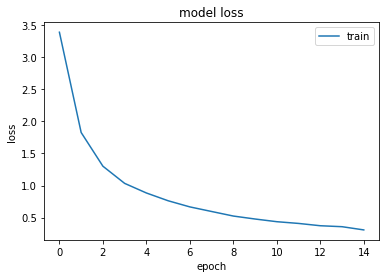

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

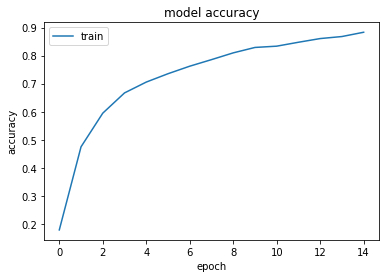

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model_dropout.evaluate(X_test, y_test) ## accuracy increased

30/30 [==============================] - 0s 10ms/step - loss: 0.9227 - accuracy: 0.7414


[0.922670841217041, 0.741416335105896]